In [17]:
import matplotlib.pyplot as plt
from Instruments import Keithley4200
import os

import time
import pandas as pd
import plotly.express as px
import numpy as np

In [18]:
KT4200 = Keithley4200(address = "TCPIP0::10.60.5.103::1225::SOCKET")
KT4200.InstInit()

KT4200.sample = "TestFastPulse"         # Sample name
KT4200.cell = 'Test'           # Measured cell
KT4200.savepath = "Test"       # Folder name (automatically created if not existing)
KT4200.lab = 'INRiM4200'       # Lab and instrument of measurement execution
KT4200.script = 'Test_fast_pulse_v2'

Keithley4200 session opened at address TCPIP0::10.60.5.103::1225::SOCKET


1e-07, 2e-08, 1e-07, 2e-08
-2, -2, 2, 2
-2, 2, 2, -2
2, 2, 2, 2
0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.0, 0.0
Status: 1

Measurement Complete.
Combined DataFrame:         Voltage       Current  Timestamp        Status
0    -0.414872  -269.6355e-6          0      01020041
1    -0.407683  -247.8783e-6      5e-09      01020041
2    -0.437874  -217.6852e-6      1e-08      01020041
3    -0.433561  -196.7436e-6    1.5e-08      01020041
4    -0.437874  -157.9864e-6      2e-08      01020041
..         ...           ...        ...           ...
235   0.499481     4.8109e-6  1.175e-06      01020041
236    0.46929  -118.7984e-6   1.18e-06      01020041
237   0.403158  -248.5228e-6  1.185e-06      01020041
238   0.239264  -367.3559e-6   1.19e-06      01020041
239  0.0480554  -479.1144e-6  1.195e-06  01020041\r\n

[240 rows x 4 columns]


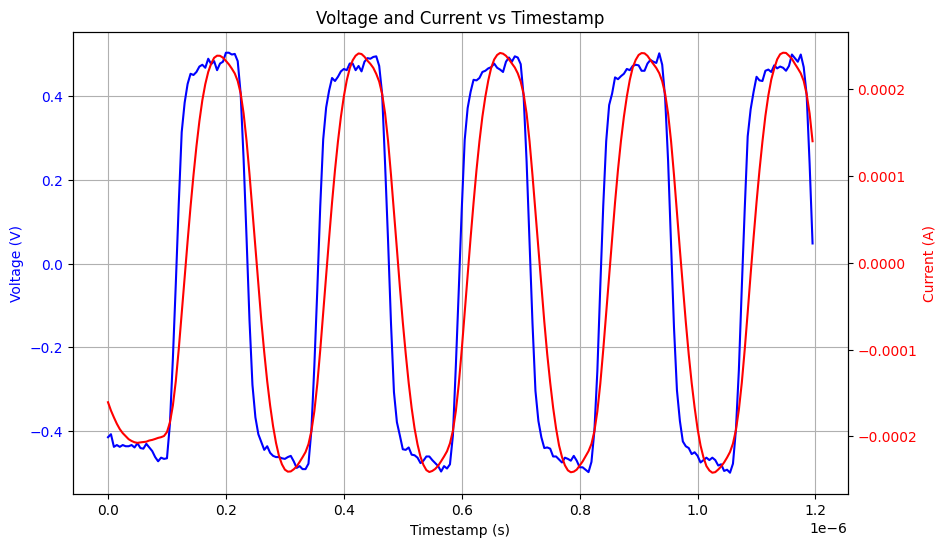

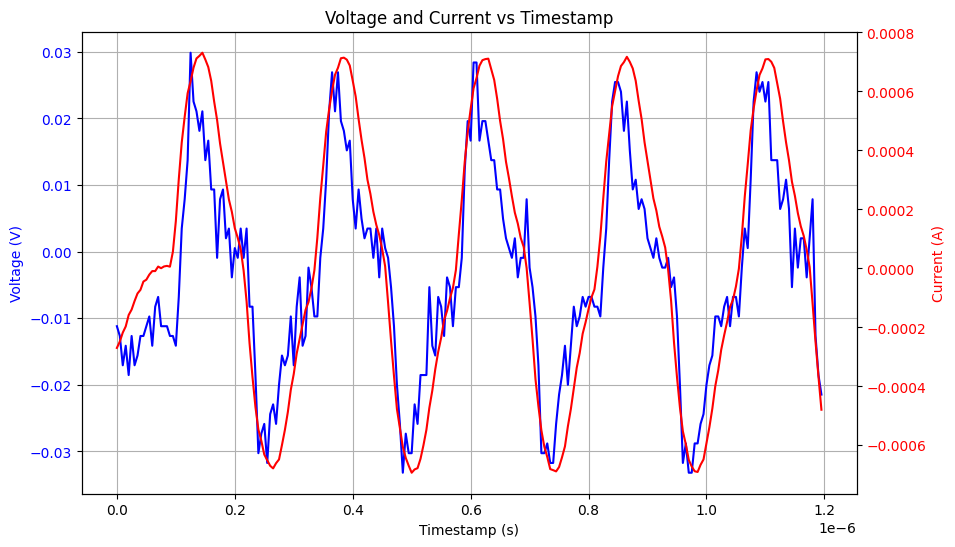

CSV file saved successfully.


In [ ]:
# Generate an array of alternated 1E-05 and 1E-07 values for a total of 82 values

pulses_number = 5
seg_number = 4
pulse_width = 10e-8
rising_time = 2e-8
v_high = 2
v_low = -2

""" SEGTIME_np = np.array([pulse_width if i % 2 == 0 else rising_time for i in range(seg_number)])
print(SEGTIME_np) """
SEGTIME = ", ".join(map(str, np.array([pulse_width if i % 2 == 0 else rising_time for i in range(seg_number)])))
print(SEGTIME)

""" STARTV_1_np = np.array([v_low if (i // 2) % 2 == 0 else v_high for i in range(seg_number)])
print(STARTV_1_np) """
STARTV_1 = ", ".join(map(str, np.array([v_low if (i // 2) % 2 == 0 else v_high for i in range(seg_number)])))
print(STARTV_1)


""" STOPV_1_np = np.roll(STARTV_1_np, -1)
print(STOPV_1_np) """
STOPV_1 = ", ".join(map(str, np.roll(np.array([v_low if (i // 2) % 2 == 0 else v_high for i in range(seg_number)]), -1)))
print(STOPV_1)

""" MEASTYPE_np = np.full(seg_number, 2)
print(MEASTYPE_np) """
MEASTYPE = ", ".join(map(str, np.full(seg_number, 2)))
print(MEASTYPE)

""" MEASSTART_np = np.zeros(seg_number)
print(MEASSTART_np) """
MEASSTART = ", ".join(map(str, np.zeros(seg_number)))
print(MEASSTART)

MEASSTOP = SEGTIME

""" STARTV_2_np  = np.zeros(seg_number) """
STARTV_2 = ", ".join(map(str, np.zeros(seg_number)))
print(STARTV_2)

""" STOPV_2_np  = np.zeros(seg_number) """
STOPV_2 = ", ".join(map(str, np.zeros(seg_number)))
print(STOPV_2)
#Initalize the PMU and set to segARB mode
KT4200.query(":PMU:INIT 1") #0 = Pulse mode, 1 = SegArb mode

ch_source = 1
ch_ground = 2
seq1 = 1

#Configure the RPM input for channel 1 of pulse card 1 to the PMU
KT4200.query(":PMU:RPM:CONFIGURE PMU1-1, 0") # 0 = PMU, 1 = CV_2W, 2 = SMU, 3 = CV_4W
#Set channel 1 for a fixed 1 mA current range
KT4200.query(f":PMU:MEASURE:RANGE {ch_source}, 2, 1e-3") # set current range, 0 = Autorange, 1 = Limited Autorange (minimum range), 2 = Fixed range


KT4200.query(f":PMU:SARB:SEQ:TIME {ch_source}, {seq1}, {SEGTIME}") # defines time sequence, Channel, sequence number (1 to 512), comma separated array of time segments (20 ns resolution)

KT4200.query(f":PMU:SARB:SEQ:STARTV {ch_source}, {seq1}, {STARTV_1}")


KT4200.query(f":PMU:SARB:SEQ:STOPV {ch_source}, {seq1}, {STOPV_1}")

KT4200.query(f":PMU:SARB:SEQ:MEAS:TYPE {ch_source}, {seq1}, {MEASTYPE}") # 0 = No measurement, 1 = Spot Mean (1 sample for seg), 2 = Waveform disrete (more samples for pulse) 

KT4200.query(f":PMU:SARB:SEQ:MEAS:START {ch_source}, {seq1}, {MEASSTART}") # set delay for measurement after segment start (0 for measuring all)

KT4200.query(f":PMU:SARB:SEQ:MEAS:STOP {ch_source}, {seq1}, {MEASSTOP}") # set time of end measuring for each segment (set equal to SEGTIME)

#Configure the RPM input for channel 2 of pulse card 1 to the PMU
KT4200.query(":PMU:RPM:CONFIGURE PMU1-2, 0")
#Set channel 2 for a fixed 1 mA current range
KT4200.query(f":PMU:MEASURE:RANGE {ch_ground}, 2, 1e-3")

#Use the same segment time as sequence 1 of channel 1 for sequence 1 of channel 2
KT4200.query(f":PMU:SARB:SEQ:TIME {ch_ground}, {seq1}, {SEGTIME}")

KT4200.query(f":PMU:SARB:SEQ:STARTV {ch_ground}, {seq1}, {STARTV_2}")


KT4200.query(f":PMU:SARB:SEQ:STOPV {ch_ground}, {seq1}, {STOPV_2}") # set V all to 0?

#Use the same measurement types, starting, and stopping values
#as sequence 1 of channel 1 for sequence 1 of channel 2
KT4200.query(f":PMU:SARB:SEQ:MEAS:TYPE {ch_ground}, {seq1}, {MEASTYPE}")
KT4200.query(f":PMU:SARB:SEQ:MEAS:START {ch_ground}, {seq1}, {MEASSTART}")
KT4200.query(f":PMU:SARB:SEQ:MEAS:STOP {ch_ground}, {seq1}, {MEASSTOP}")


#Set the waveform sequence lists for channels 1 and 2
KT4200.query(f":PMU:SARB:WFM:SEQ:LIST {ch_source}, {seq1}, {pulses_number}") # define for each sequence how many times is in output
KT4200.query(f":PMU:SARB:WFM:SEQ:LIST {ch_ground}, {seq1}, {pulses_number}")

#Set the output state for channels 1 and 2 to on
KT4200.query(f":PMU:OUTPUT:STATE {ch_source}, 1") # set to 1 = ON before EXECUTE (turns on after execute0, set to 0 = OFF at the end of test)
KT4200.query(f":PMU:OUTPUT:STATE {ch_ground}, 1")

#Execute the test
KT4200.query(":PMU:EXECUTE") # performs checks and starts test execution 

#This is a loop to check the status of the test
#The :PMU:TEST:STATUS? command returns 1 if it is still running and 0 if it is idle
while True:
    status = KT4200.query(":PMU:TEST:STATUS?")
    
    #Continues loop until the test is complete
    #Casting the status string to int makes the comparison simpler since it ignores the termination characters
    if int(status) == 0:
        print("Measurement Complete.")
        break
    
    #Continously prints the status of the test every second to the terminal
    print(f"Status: {status}")
    time.sleep(1)


# Get the total number of data points
data_points_str = KT4200.query(":PMU:DATA:COUNT? 1")
data_points = int(data_points_str)

# Initialize an empty DataFrame to store all data points
df_all_channels = pd.DataFrame(columns=['Voltage', 'Current', 'Timestamp', 'Status'])
df_all_channels_2 = pd.DataFrame(columns=['Voltage', 'Current', 'Timestamp', 'Status'])


# Loop through the data points in chunks
for start_point in range(0, data_points, 2048):
    # Get data for the current chunk
    response = KT4200.query(f":PMU:DATA:GET 1, {start_point}, 2048")

    # Split the response using semicolon as the delimiter for each point
    coords = response.split(";")

    # Split into 4 separate values for each point
    coords2d = [value.split(",") for value in coords]

    # Create a DataFrame for the current chunk
    df_chunk = pd.DataFrame(coords2d, columns=['Voltage', 'Current', 'Timestamp', 'Status'])

    # Concatenate the current chunk to the overall DataFrame
    df_all_channels = pd.concat([df_all_channels, df_chunk])

    response_2 = KT4200.query(f":PMU:DATA:GET 2, {start_point}, 2048")

    # Split the response using semicolon as the delimiter for each point
    coords_2 = response_2.split(";")

    # Split into 4 separate values for each point
    coords2d_2 = [value.split(",") for value in coords_2]

    # Create a DataFrame for the current chunk
    df_chunk_2 = pd.DataFrame(coords2d_2, columns=['Voltage', 'Current', 'Timestamp', 'Status'])

    # Concatenate the current chunk to the overall DataFrame
    df_all_channels_2 = pd.concat([df_all_channels_2, df_chunk_2])

#Set the output state of channels 1 and 2 to off - always turn off the output at the end of a test
KT4200.query(f":PMU:OUTPUT:STATE {ch_source}, 0")
KT4200.query(f":PMU:OUTPUT:STATE {ch2}, 0")

# Reset the index of the final DataFrame
df_all_channels.reset_index(drop=True, inplace=True)

# Print the combined DataFrame
print("Combined DataFrame: ", df_all_channels)

# Convert 'Voltage', 'Current', and 'Timestamp' columns to appropriate types
df_all_channels['Voltage'] = df_all_channels['Voltage'].astype(float)
df_all_channels['Current'] = df_all_channels['Current'].astype(float)
df_all_channels['Timestamp'] = df_all_channels['Timestamp'].astype(float)

df_all_channels_2['Voltage'] = df_all_channels_2['Voltage'].astype(float)
df_all_channels_2['Current'] = df_all_channels_2['Current'].astype(float)
df_all_channels_2['Timestamp'] = df_all_channels_2['Timestamp'].astype(float)

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Voltage on the left y-axis
ax1.plot(df_all_channels['Timestamp'], df_all_channels['Voltage'], color='b', label='Voltage')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('Voltage (V)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for Current
ax2 = ax1.twinx()
ax2.plot(df_all_channels_2['Timestamp'], -df_all_channels_2['Current'], color='r', label='Current')
ax2.set_ylabel('Current (A)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and grid
plt.title('Voltage and Current vs Timestamp')
ax1.grid()

# Show the plot
plt.show()# Convert 'Voltage', 'Current', and 'Timestamp' columns to appropriate types
df_all_channels['Voltage'] = df_all_channels['Voltage'].astype(float)
df_all_channels['Current'] = df_all_channels['Current'].astype(float)
df_all_channels['Timestamp'] = df_all_channels['Timestamp'].astype(float)

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Voltage on the left y-axis
ax1.plot(df_all_channels_2['Timestamp'], df_all_channels_2['Voltage'], color='b', label='Voltage')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('Voltage (V)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for Current
ax2 = ax1.twinx()
ax2.plot(df_all_channels['Timestamp'], df_all_channels['Current'], color='r', label='Current')
ax2.set_ylabel('Current (A)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and grid
plt.title('Voltage and Current vs Timestamp')
ax1.grid()

# Show the plot
plt.show()

# Convert columns to appropriate types, floating point for the voltage and current, and a string for the timestamp and status
df_all_channels = df_all_channels.astype({'Voltage': float, 'Current': float, 'Timestamp': str, 'Status': str})

# Save DataFrame to a CSV file
df_all_channels.to_csv('data_table.csv', index=False)
print("CSV file saved successfully.")  # Verify the data was saved

# Scatter plot with Voltage High and Current High on the plot, and all data in hover
fig = px.scatter(df_all_channels, x='Timestamp', y='Voltage',
                 title='PMU SEGARB COMPLETE',
                 labels={'Timestamp': 'Time Output (s)', 'Voltage': 'Voltage (V)'},
                 hover_data=["Timestamp", "Voltage"])

# Add a line trace
fig.add_trace(px.line(df_all_channels, x='Timestamp', y='Voltage').data[0])

# Set a linear x-axis
fig.update_xaxes(type='linear')

# Show the plot
fig.show()

In [20]:
KT4200.sourceOFF()

In [21]:
KT4200.session.query(f"SS RP SMU{KT4200.ch_ground}, 2")
KT4200.session.query(f"SS RP SMU{KT4200.ch_source}, 2")

'ACK'

In [22]:
#KT4200.query("DCL")

In [23]:
#KT4200.SPol()
KT4200.closeSession()